In [17]:
# Core imports
import numpy as np
from numpy import linalg as la 
import heyoka as hk
import pykep as pk
import pandas as pd
import math
from numpy.lib.function_base import append
from scipy.integrate import odeint

# Sys imports
import time

# Plot imports
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as mtick

# Other imports
from UROP_const import *
from UROP_aux_func import *

%matplotlib notebook

In [18]:
#create heyoka variables
X,Y,Z = hk.make_vars("X","Y","Z")
VX,VY,VZ = hk.make_vars("VX","VY","VZ")

In [19]:
# Non dimensionalise the parameters
GMe_hat = GMe * a0d / (a0d * GMe) # = 1
Re_hat  = Re / a0d
rl_hat  = rl / (6*Re)
omega_l_hat = omega_l * math.sqrt((a0d**3)/GMe)
GMl_hat = GMl * a0d / (a0d * GMe)

In [20]:
# Step 1: Define Initial Conditions (dimensional)
r0d = np.array([0.0, -5888.9727, -3400.0]) #km   (class 'numpy.ndarray')
v0d = np.array([10.691338, 0.0, 0.0])      #km/s
[a0d, e0d, i0d, RAAN0d, omega0d, theta0d] = state2orb(r0d, v0d, GMe)
print([a0d, e0d, i0d, RAAN0d, omega0d, theta0d])
# Step 2: Non-dimensionalise (it is a good practice in order to compare order of magnitude of perturbations
# more meaninfully and also for numerical errors)
r0 = r0d / a0d #[km/km] = [-] since the orbit is highly elliptical normalise with the initial semimajor axis
               # otherwise use r0 = r0d/la.norm(r0d)
v0 = v0d * math.sqrt(a0d/GMe)      #[-]
t0d = 0 #s
t0  = t0d / math.sqrt((a0d**3)/GMe) #[-]
# Non-dimensional ICs
S0 = [*r0, *v0]

[136000.41845656614, 0.9500001541350792, 0.5235987789611063, 0.0, 4.71238898038469, 1.4901161193847656e-08]


In [72]:
#Earth's Keplerian terms
#r = math.sqrt(X**2 + Y**2 + Z**2) this is not supported by heyoka
magR2 = X**2 + Y**2 + Z**2
r = (magR2)**(1/2)
fKepX = -GMe_hat*X/(magR2**(3./2))
fKepY = -GMe_hat*Y/(magR2**(3./2))
fKepZ = -GMe_hat*Z/(magR2**(3./2))

#Earth's J2 terms
fJ2X = (-GMe_hat/(r**3)) * X + ( (3/2)*J2*GMe_hat*Re_hat**2/r**4 ) * (X/r)*(5*(Z**2/r**2) -1)
fJ2Y = (-GMe_hat/(r**3)) * Y + ( (3/2)*J2*GMe_hat*Re_hat**2/r**4 ) * (Y/r)*(5*(Z**2/r**2) -1)
fJ2Z = (-GMe_hat/(r**3)) * Z + ( (3/2)*J2*GMe_hat*Re_hat**2/r**4 ) * (Z/r)*(5*(Z**2/r**2) -3)

# The lunar position is not defined by an ephemeris model but by trigonometric functions based on the time of the
# integration. r ([x, y, z]) is the satellite position, page 23.
iI = np.array([1, 0, 0])
jI = np.array([0, 1, 0])
kI = np.array([0, 0, 1])

r3      = np.array([ rl_hat * hk.sin(omega_l_hat*hk.time),  
                    - rl_hat * hk.cos(omega_l_hat*hk.time)/2 * math.sqrt(3),  
                    - rl_hat * hk.cos(omega_l_hat*hk.time)/2 ])

# rl_hat * (hk.sin(omega_l_hat*hk.time)*iI - hk.cos(omega_l_hat*hk.time)/2 * (math.sqrt(3)*jI + kI))
r3_norm = (r3[0]**2 + r3[1]**2 + r3[2]**2)**(1/2)
rL      = r3 - np.array([X, Y, Z])
rL_norm = (rL[0]**2 + rL[1]**2 + rL[2]**2)**(1/2)

acc_lunar = GMl_hat * ( rL / (rL_norm**3) - r3 / r3_norm**3)

fLX = acc_lunar[0]
fLY = acc_lunar[1]
fLZ = acc_lunar[2]

#fLX = GMl_hat * ( rL / (rL_norm**3) - r3 / r3_norm**3)


#fLY = acc_lunar[1]
#fLZ = acc_lunar[2]


In [73]:
#EOMs
dXdt = VX
dYdt = VY
dZdt = VZ
dVXdt = fKepX + fJ2X + fLX 
dVYdt = fKepY + fJ2Y + fLY 
dVZdt = fKepZ + fJ2Z + fLZ

In [74]:
ic = [*r0, *v0]

print('Compiling the Taylor integrator ... (this is done only once)')
start_time = time.time()

ta = hk.taylor_adaptive(sys = [(X,dXdt),(Y,dYdt),(Z,dZdt),(VX,dVXdt),(VY,dVYdt),(VZ,dVZdt)],
                        state = ic,
                        time = t0,
                        tol = 1e-16,
                        compact_mode = True)
end_time = time.time()

print('Done, in');
print("--- %s seconds ---" % (end_time - start_time))

print("\nHeyoka Taylor integrator:\n", ta)

Compiling the Taylor integrator ... (this is done only once)
Done, in
--- 0.832819938659668 seconds ---

Heyoka Taylor integrator:
 Taylor order            : 20
Dimension               : 6
Time                    : 0.0000000000000000
State                   : [0.0000000000000000, -0.043301136620257794, -0.024999923078073787, 6.2450078709672967, 0.0000000000000000, 0.0000000000000000]



In [75]:
tfd = 288.12768941*24*3600                   # s
tmax  = tfd / math.sqrt((a0d**3)/GMe)          #[-]
print(tmax)


# How often to log the state
dtd = 3600*5 #[sec]
dt = dtd / math.sqrt((a0d**3)/GMe)          #[-]
print(dt)
print(tfd/dtd)
# Here we redefine the initial conditions since we may want to change them without recompiling the integrator
ta.time = t0
# Note the python syntax to assign directly the array elements. Here necessary
# as heyoka does not allow to change the memory location of the state
ta.state[:] =  [*r0, *v0] #[x0,y0,z0,vx0,vy0,vz0]

313.3701056121452
0.22658509080776693
1383.012909168


In [81]:
tgrid = np.linspace(t0, tmax, int(1 + tmax/dt), endpoint = True)
print(np.shape(tgrid))

(1384,)


In [82]:
#tgrid = np.linspace(t0, tmax, int(1 + tmax/dt), endpoint = True)

start_time = time.time()
out = ta.propagate_grid(tgrid)
end_time = time.time()

print('Done, in');
print("--- %s seconds ---" % (end_time - start_time))
sol = out[4] 
size = np.shape(sol)
print(f'the shape of the solution (cartesian form) is {size}')

Done, in
--- 1.5982699394226074 seconds ---
the shape of the solution (cartesian form) is (1384, 6)


In [84]:
# Dimensionalise and Convert to Keplerian Elements
pos = sol[:, :3]
vel = sol[:, -3:]
# Dimensionalise the output state
pos_km  = np.empty((size[0], 3))
vel_kms = np.empty((size[0], 3))
for row in range(size[0]):
    pos_km[row, :]  = pos[row]*a0d
    vel_kms[row, :] = vel[row]/math.sqrt(a0d/GMe)
    
np.savetxt("cowell_hkpos.txt", pos_km)
np.savetxt("cowell_hkvel.txt", vel_kms)

# Convert to classical elements the dimensionalised state
state2orb_res = np.empty((size[0], 6)) 
for item in range(size[0]):
    state2orb_res[item, :] = state2orb(pos_km[item], vel_kms[item], GMe)

In [85]:
t_days = np.empty((size[0], 1))
for t, i in zip(tgrid, range(size[0])):
    t_days[i, 0] = ( t * math.sqrt((a0d**3)/GMe) )/(24*3600)
        

              a         e         i      RAAN     omega     theta
0  1.360004e+05  0.950000  0.523599  0.000000  4.712389  0.000000
1  1.361851e+06  1.004882  0.523918  6.263796  3.075451  0.050349
2  1.351434e+05  1.050261  0.523595  6.244639  1.437667  6.273376
3  4.610916e+05  0.985511  0.523898  6.225110  6.084456  6.234785
4  1.463800e+05  0.953631  0.523618  6.206019  4.446248  0.019120


<IPython.core.display.Javascript object>


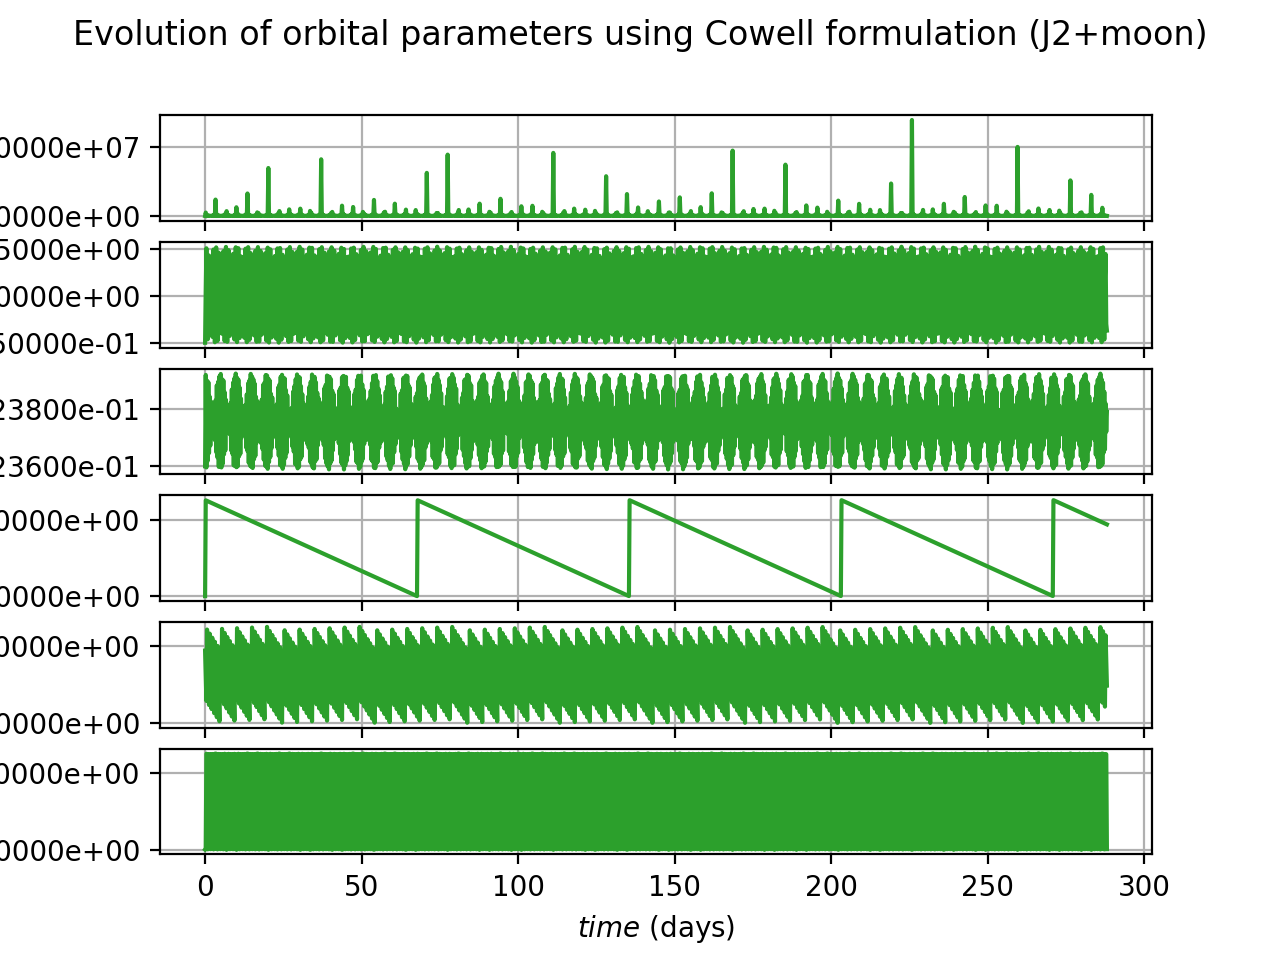

In [86]:
df = pd.DataFrame(state2orb_res, columns=["a", "e", "i", "RAAN", "omega", "theta"])
print(df.head())
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, sharex=True)
fig.suptitle('Evolution of orbital parameters using Cowell formulation (J2+moon)')
ax1.plot(t_days, df["a"], 'tab:green')
    # ax1.set_title('a')
ax1.set(ylabel=r"$a$ (km)")
ax2.plot(t_days, df["e"], 'tab:green')
    # ax2.set_title('e')
ax2.set(ylabel=r"$e$ (-)")
ax3.plot(t_days, df["i"], 'tab:green')
ax3.set(ylabel=r"$i$ (rads)")
ax4.plot(t_days, df["RAAN"], 'tab:green')
ax4.set(ylabel=r"$\Omega$ (rads)")
ax5.plot(t_days, df["omega"], 'tab:green') 
ax5.set(ylabel=r"$\omega$ (rads)")
ax6.plot(t_days, df["theta"], 'tab:green')
ax6.set(xlabel=r"$time$ (days)", ylabel=r"$\theta$ (rads)")
    # xlabel="time (days) to last subplot only
    # Add a grid to subplots
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax6.grid()
    # Reformat the y axis notation
ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.5e'))
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.5e'))
ax3.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.5e'))
ax4.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.5e'))
ax5.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.5e'))
ax6.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.5e'))
plt.show()

plt.savefig('Cowell_heyoka_j2+moon.png', dpi=300, bbox_inches='tight')